In [1]:
# Libraries
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV 
from sklearn.linear_model import Perceptron, LogisticRegressionCV, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Lasso
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,mean_absolute_error, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve, auc, classification_report,precision_score,recall_score,log_loss,f1_score
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, AdaBoostClassifier
from bayes_opt import BayesianOptimization
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, LabelEncoder, OneHotEncoder, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer,minmax_scale
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
import pandas_bokeh
from sklearn.decomposition import PCA, KernelPCA
from sklearn.calibration import CalibratedClassifierCV
from numpy import mean, std
import pandas.testing as tm
from scipy import stats
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import ExtraTreeClassifier
from skopt import BayesSearchCV

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

#other
from math import sqrt
import inspect
from matplotlib.font_manager import FontProperties
from scipy.stats import loguniform, uniform

import eli5

from yellowbrick.features import Rank2D
from yellowbrick.features import PCA as PCA_YB
from yellowbrick.features.radviz import RadViz
from yellowbrick.features import pca_decomposition
from yellowbrick.features import Manifold
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import LearningCurve
from yellowbrick.model_selection import CVScores
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import ParallelCoordinates
from yellowbrick.model_selection import RFECV
from yellowbrick.classifier import ROCAUC

In [2]:
DATASET_URL = "https://gist.githubusercontent.com/YHYeoh/ad1a7f7170c72d621d05a70637540152/raw/5a6059c199e2c46d2f3d258f03d93cfea98e2749/marketing_campaign.csv"
data = pd.read_csv(DATASET_URL, sep = ';')

pd.set_option('plotting.backend','pandas_bokeh')

data.fillna(method = "ffill", inplace = True)
data.isnull().values.any()

label_encoder = LabelEncoder()
enc = OneHotEncoder()

data["Education"] = label_encoder.fit_transform(data["Education"])
print(label_encoder.classes_)
# enc_df = pd.DataFrame(enc.fit_transform(data[["Marital_Status"]]).toarray())
# print(enc.get_feature_names())
# data = data.join(enc_df)

marital_status_ohe = pd.get_dummies(data["Marital_Status"],prefix="Marital")
ohe_cols = marital_status_ohe.columns
data = pd.concat([data, marital_status_ohe], axis=1)


data['enroll_year'] = pd.DatetimeIndex(data.Dt_Customer).year
data['enroll_month'] = pd.DatetimeIndex(data.Dt_Customer).month
data['enroll_day'] = pd.DatetimeIndex(data.Dt_Customer).day

data.drop(["ID", 'Dt_Customer',"Z_CostContact","Z_Revenue","Marital_Status"], axis=1, inplace=True)

categorical = ['Marital_Status']
numerical = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'enroll_year', 'enroll_month', 'enroll_day']
numerical_no_bool = ['Education','Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth','enroll_day','enroll_month','enroll_year']

y = data.Response
print(y.value_counts())
X = data.drop(['Response'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.3)

['2n Cycle' 'Basic' 'Graduation' 'Master' 'PhD']
0    1906
1     334
Name: Response, dtype: int64


In [3]:
def hasmethod(obj, name):
	return inspect.ismethod(getattr(obj, name, None))

def ROC_Curve_Plot(model,X_test,y_test,name):
	predProb = model.predict_proba(X_test)
	preds = predProb[:,1]
	fpr, tpr, threshold = roc_curve(y_test, preds,pos_label=1)
	roc_auc = auc(fpr, tpr)
	plt.close()
	plt.title(name+' Receiver Operating Characteristic')
	plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
	plt.legend(loc = 'lower right')
	plt.plot([0, 1], [0, 1],'r--')
	plt.ylabel('True Positive Rate')
	plt.xlabel('False Positive Rate')
	plt.show()
	return fpr,tpr

def setupPreprocessPipeline(scaler):
	ss = Pipeline(steps=[('scaler',scaler)])
	#ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown = 'ignore'))])
	preprocess = ColumnTransformer(
                    transformers=[
                        ('cont', ss, numerical_no_bool)
                        #('cat', ohe, categorical),
                        #('le', le, ordinal),
                        ],remainder='passthrough')
	return preprocess

def feature_importance(classifier, feature_names, scaler_name):
	if (hasattr(classifier,'coef_')):
		importance = classifier.coef_[0]
	elif (hasattr(classifier,'coefs_')):
		importance = classifier.coefs_
	elif (hasattr(classifier,'feature_importances_')):
		importance = classifier.feature_importances_
	else:
		print("Cannot extract feature importance, skipping")
		return

	#for i,v in enumerate(importance):
	#	print('Feature: %d, Score: %.5f' % (i,v))
	zipped = zip(feature_names, importance)
	df = pd.DataFrame(zipped, columns=["feature", "value"])
	# Sort the features by the absolute value of their coefficient
	df["abs_value"] = df["value"].apply(lambda x: abs(x))
	df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
	df = df.sort_values("abs_value", ascending=False)
	# plot feature importance
	fig, ax = plt.subplots(1, 1, figsize=(16, 9))
	sns.barplot(x="feature",
	            y="value",
	            data=df.head(20),
	           palette=df.head(20)["colors"])
	plt.gcf().subplots_adjust(bottom=0.30)
	ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=14)
	ax.set_title("Top 20 Features for {} w/ {}".format(classifier.__class__.__name__, scaler_name), fontsize=25)
	ax.set_ylabel("Coef", fontsize=22)
	ax.set_xlabel("Feature Name", fontsize=22)
	plt.show()

def evaluation(y, y_hat, title):
	cm = confusion_matrix(y, y_hat)
	precision = precision_score(y, y_hat)
	recall = recall_score(y, y_hat)
	accuracy = accuracy_score(y,y_hat)
	f1 = f1_score(y,y_hat)
	print('Recall: ', recall)
	print('Accuracy: ', accuracy)
	print('Precision: ', precision)
	print('F1: ', f1)
	sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
	plt.xlabel('predicted', fontsize=18)
	plt.ylabel('actual', fontsize=18)
	plt.title(title, fontsize=18)
	plt.show()
    
def metrics_summary(y_test,y_pred):
	tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
	accuracy=accuracy_score(y_test, y_pred)
	precision = precision_score(y_test, y_pred)
	recall =  recall_score(y_test, y_pred) #sensitivity
	specificity = tn / (tn+fp)
	g_mean= sqrt(recall * specificity)
	mse =mean_squared_error(y_test, y_pred, squared=False)
	r2=r2_score(y_test, y_pred)
	ros = roc_auc_score(y_test, y_pred)
	ll = log_loss(y_test, y_pred)
	f1 = f1_score(y_test, y_pred)
	
	metrics_collection_dict ={
        'accuracy':['accuracy',accuracy],
        'precision':['precision',precision],
        'recall':['recall',recall],
        'specificity':['specificity',specificity],
        'g_mean':['g_mean',g_mean],
        'mean_square_error':['mean_square_error',mse],
        'r2':['r2',r2],
        'roc_auc_score':['roc_auc_score',ros],
        'log_loss':['log_loss',ll],
        'f1_score':['f1_score',f1]
    } 
	return metrics_collection_dict

def correlationPlot():
	visualizer = Rank2D(
        features=X.columns, algorithm='covariance'
    )
	visualizer.fit(X, y)                # Fit the data to the visualizer
	visualizer.transform(X)             # Transform the data
	visualizer.show()                   # Finalize and render the figure

def radVisualize():
	visualizer = RadViz() #nice
	visualizer.fit(X, y)
	visualizer.transform(X)
	visualizer.show()
def pca_scatter_plot():
	visualizer = pca_decomposition(X, y, scale=True, classes=['yes','no'])
	visualizer.show()
def precision_recall_curve(model):
	viz = PrecisionRecallCurve(model)
	viz.fit(X_train, y_train)
	viz.score(X_test, y_test)          #ok
	viz.show()
    
def overallClassificationReport(model,classes):
	visualizer = ClassificationReport(model, classes=classes, support=True) #might can change
	visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
	visualizer.score(X_test, y_test)        # Evaluate the model on the test data
	visualizer.show()

def class_predict_err_plot(model,classes):
	visualizer = ClassPredictionError(model, classes=classes)
	# Fit the training data to the visualizer
	visualizer.fit(X_train, y_train)
	# Evaluate the model on the test data
	visualizer.score(X_test, y_test)
	# Draw visualization
	visualizer.show()

def learning_curve_plot(model):
	cv = StratifiedKFold(n_splits=12)
	sizes = np.linspace(0.3, 1.0, 10)

	# Instantiate the classification model and visualizer
	visualizer = LearningCurve(
	    model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
	)
	visualizer.fit(X, y)        # Fit the data to the visualizer
	visualizer.show()
    
def cv_scores_plot(model):
	cv = StratifiedKFold(n_splits=12, random_state=42, shuffle= True)
	visualizer = CVScores(model, cv=cv, scoring='f1_weighted')

	visualizer.fit(X, y)        # Fit the data to the visualizer
	visualizer.show()
def overall_feature_importance(model):
	labels = list(map(lambda s: s.title(), X.columns))
	viz = FeatureImportances(model, labels=labels, relative=False, topn = 8)
	viz.fit(X, y)
	viz.show()
def RFECV_plot(model):
	cv= StratifiedKFold(5)
	# Instantiate RFECV visualizer with a linear SVM classifier
	visualizer = RFECV(model, cv= cv)
	visualizer.fit(X, y)        # Fit the data to the visualizer
	visualizer.show()      #ok

In [38]:
from sklearn.ensemble import VotingClassifier
classifiers =[('gbc',GradientBoostingClassifier()),('rfc',RandomForestClassifier()),('lgbm',LGBMClassifier())
              ,('svc',SVC(probability=True)),('rid',RidgeClassifier())]

def votingClassifierReport(classifiers,voting):
    usableClassifier = []
    if(voting =='soft'):
        for i in classifiers:
            if hasattr(i[1],'predict_proba'):
                usableClassifier.append(i)
    else:
        usableClassifier = classifiers
    classes =['yes','no']
    #majority voting
    in_use_classifiers=""
    for i in usableClassifier:
        in_use_classifiers = in_use_classifiers+" "+str(i[1].__class__.__name__)
    print("Classifiers: "+in_use_classifiers)
    voting = VotingClassifier(estimators=usableClassifier, voting=voting)
    overallClassificationReport(voting,classes)


Classifiers:  GradientBoostingClassifier RandomForestClassifier LGBMClassifier SVC RidgeClassifier


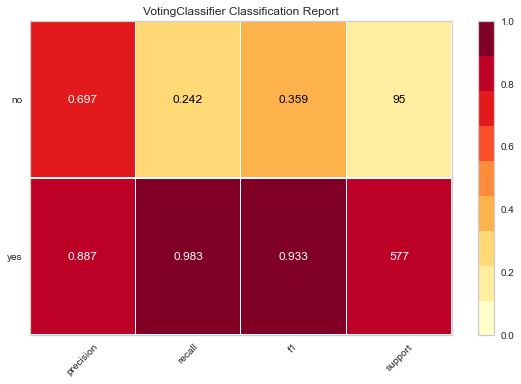

In [39]:
votingClassifierReport(classifiers,'hard')

Classifiers:  GradientBoostingClassifier RandomForestClassifier LGBMClassifier SVC


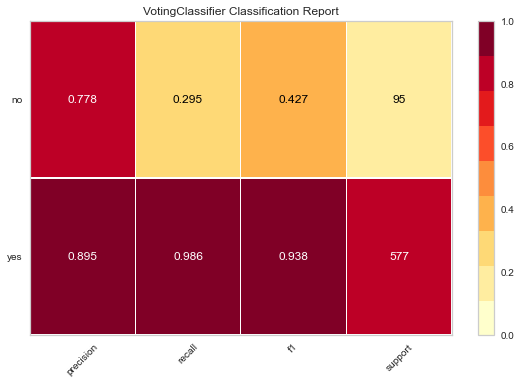

In [40]:
votingClassifierReport(classifiers,'soft')

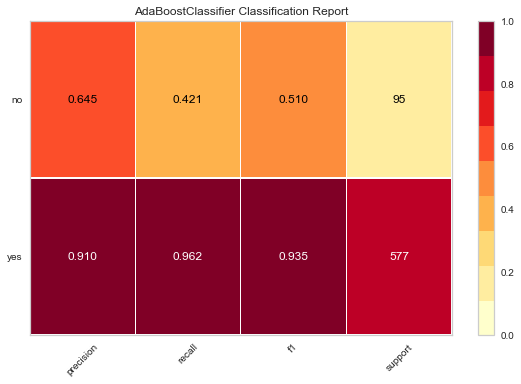

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=100)

overallClassificationReport(ada,classes)

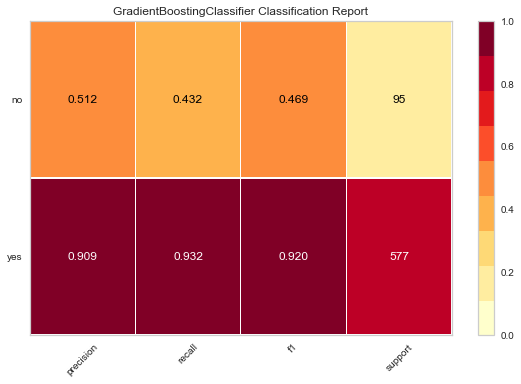

In [22]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3, random_state=0).fit(X_train, y_train)
overallClassificationReport(clf,classes)

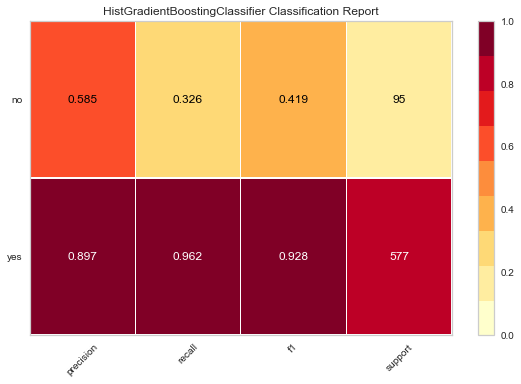

In [21]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

clf = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
overallClassificationReport(clf,classes)

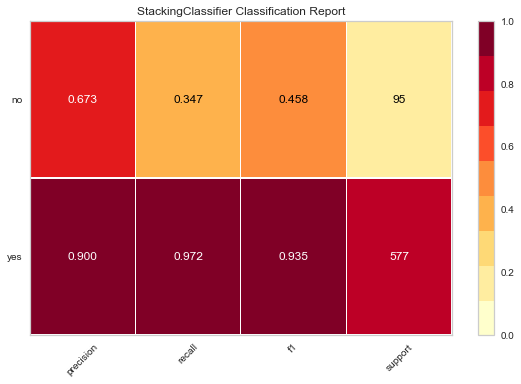

In [9]:
from sklearn.ensemble import StackingClassifier
def stackingClassifier(classifiers):
    clf = StackingClassifier(estimators=classifiers,cv=10)
    overallClassificationReport(clf,classes)

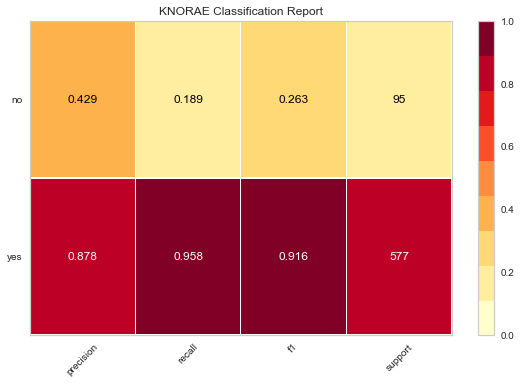

In [20]:
from sklearn.ensemble import RandomForestClassifier
from deslib.des.knora_e import KNORAE
# Train a pool of 10 classifiers
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)


# Initialize the DES model
#knorae = KNORAE(pool_classifiers)

o#verallClassificationReport(knorae,classes)

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import BaggingClassifier


In [4]:
from deslib.dcs.ola import OLA
from deslib.dcs.a_priori import APriori
from deslib.dcs.mcb import MCB

#import DES techniques from DESlib
from deslib.des.des_p import DESP
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.des.meta_des import METADES

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

#initialize pool classifier



In [49]:
def bestDesLibClassifiersByF1(pool_classifiers,X_train,y_train,X_test,y_test):
    deslibEnsClassifiers= [OLA(pool_classifiers),MCB(pool_classifiers),APriori(pool_classifiers)
                       ,KNORAU(pool_classifiers),KNORAE(pool_classifiers),DESP(pool_classifiers)
                      ,METADES(pool_classifiers)]
    X_train, X_dsel, y_train, y_dsel = train_test_split(X_train, y_train, test_size=0.5)
    best_classifier= None
    best_score= 0
    for model in deslibEnsClassifiers:
        model = model.fit(X_train,y_train)
        y_pred = model.predict(X_dsel)
        f1 = f1_score(y_dsel,y_pred)
        if f1>best_score:
            best_score=f1
            best_classifier = model
    
    return {'best_classifier':best_classifier,'f1_score':best_score}

def getBaggingBasedPoolClassifier(baseClassifier):
    model = CalibratedClassifierCV(baseClassifier)
    pool_classifiers = BaggingClassifier(model,n_estimators=10)
    pool_classifiers.fit(X_train, y_train)
    return pool_classifiers

In [50]:
pool_classifiers = getBaggingBasedPoolClassifier(GradientBoostingClassifier())# Perceptron(max_iter=10) #SVC #DecisionTree #GradientBoostingClassifier 
result = bestDesLibClassifiersByF1(pool_classifiers,X_train,y_train,X_test,y_test)

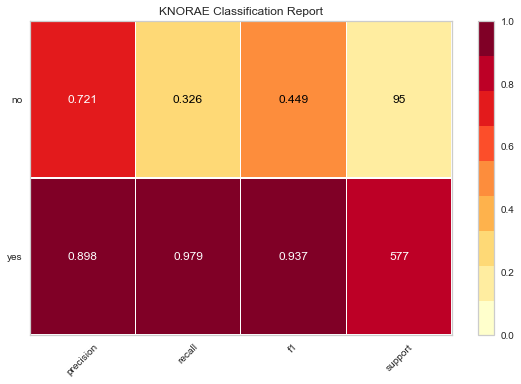

In [51]:
best_class = result['best_classifier']
overallClassificationReport(best_class,['yes','no'])

In [22]:
result

TypeError: 'METADES' object is not subscriptable

In [48]:
from sklearn.utils import all_estimators

estimators = all_estimators()

#run all classifier with predict_proba to check best estimator
best_estimator = None
best_score = 0
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba') and (hasattr(class_, 'best_estimator_')==False):
        if(hasattr(class_(), 'classes_')==False):
            name = class_().__class__.__name__
            if(name!="CalibratedClassifierCV"):
                print(class_().__class__.__name__)
                pool_classifiers = getBaggingBasedPoolClassifier(class_())# Perceptron(max_iter=10) #SVC #DecisionTree #GradientBoostingClassifier 
                result = bestDesLibClassifiersByF1(pool_classifiers,X_train,y_train,X_test,y_test)
                selected_classifier = result['best_classifier']
                f1_result = result['f1_score']
                print(selected_classifier,f1_result)
                if(f1_result>best_score):
                    best_estimator = selected_classifier
                    best_score = f1_result
best = best_estimator
score = best_score
print(best,score)
        

AdaBoostClassifier
METADES(pool_classifiers=BaggingClassifier(base_estimator=CalibratedClassifierCV(base_estimator=AdaBoostClassifier()))) 0.5595238095238095
BaggingClassifier
METADES(pool_classifiers=BaggingClassifier(base_estimator=CalibratedClassifierCV(base_estimator=BaggingClassifier()))) 0.8481675392670157
BayesianGaussianMixture


C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\sklearn\calibration.py:289: UserWarning: Since BayesianGaussianMixture does not support sample_weights, sample weights will only be used for the calibration itself.
  warnings.warn(f"Since {estimator_name} does not support "


AttributeError: 'BayesianGaussianMixture' object has no attribute 'classes_'